In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.dates import DateFormatter


# Crime Forecast

In [2]:
plt.style.use('seaborn-colorblind')

def crime_forecasting(df):
    df.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,'date',23,24,25,26,'crime_index',28]
    df['date'] = pd.to_datetime(df['date'])
    df_sorted = df.sort_values(by = ['date'])
    temp = df_sorted[['date','crime_index']]
    temp['month'] = temp['date'].dt.strftime('%Y/%m')
    temp = temp.groupby('month')['crime_index'].sum().reset_index()
    temp['date'] = pd.to_datetime(temp['month'])
    temp = temp.set_index('date')
    y = temp['crime_index'].resample('MS').mean()
    #temp.plot(figsize=(15, 6))
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    
    ## Find the lowest AIC and its corresponding parameters
    lowest_aic = 9999
    corr_param = 0
    corr_param_seasonal = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,order=param,
                                                  seasonal_order=param_seasonal,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                results = mod.fit()
                temp_aic = results.aic
                if temp_aic < lowest_aic:
                    lowest_aic = temp_aic
                    corr_param = param
                    corr_param_seasonal = param_seasonal
            except:
                   continue

    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=corr_param,
                                    seasonal_order=corr_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()    

    
    #prediction
    pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = y['2009':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='my one step ahead forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Crime Score')
    plt.legend()
    
    plt.show()
    
    
    pred_uc = results.get_forecast(steps=50)
    pred_ci = pred_uc.conf_int()
    ax = y.plot(label='actual data', figsize=(10, 5))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    #ax.fill_between(pred_ci.index,
    #                pred_ci.iloc[:, 0],
    #                pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Crime Score')
    plt.legend()
    plt.show()
    expected_crime = pred_uc.predicted_mean['2019-06-01']

    return expected_crime, y, pred_uc.predicted_mean

# Forecasting for each neighborhood

- Comment: there are 256 neighborhoods in Atlanta

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


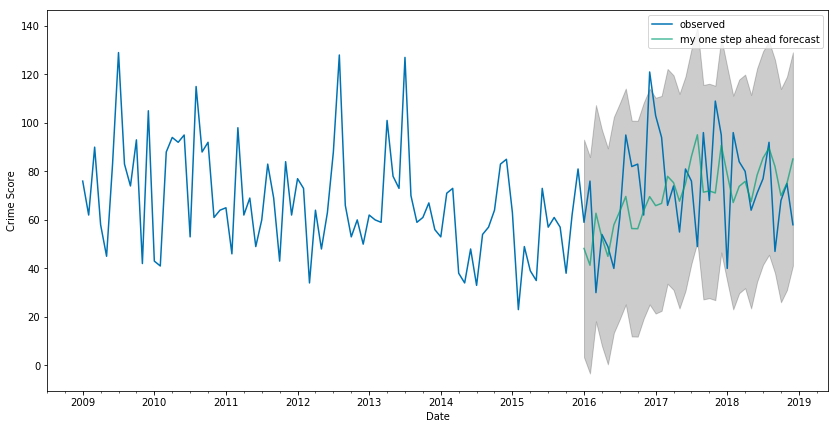

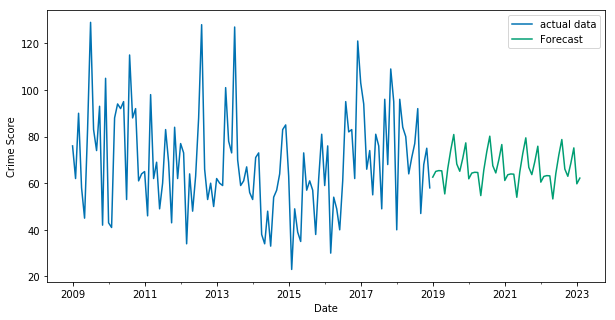

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


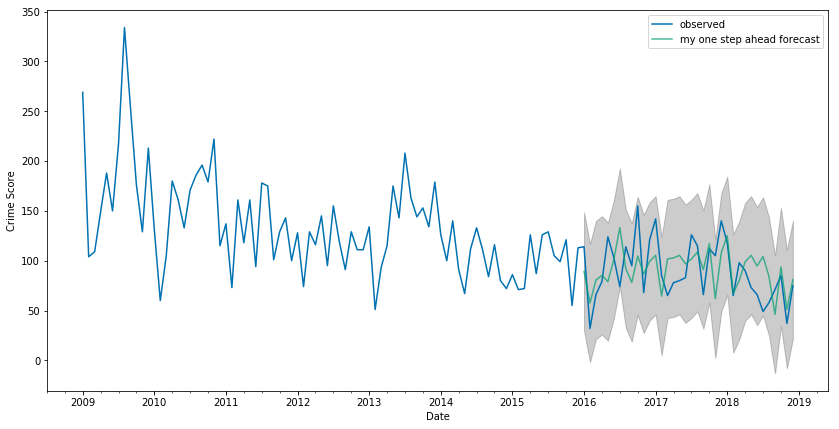

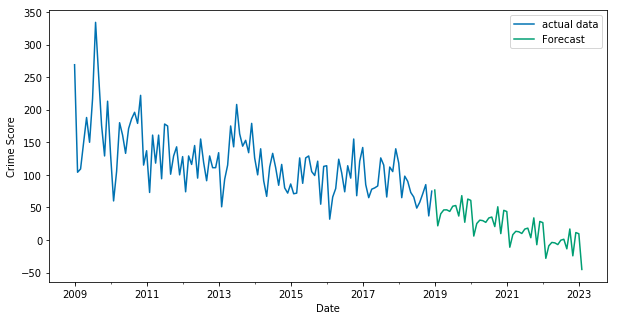

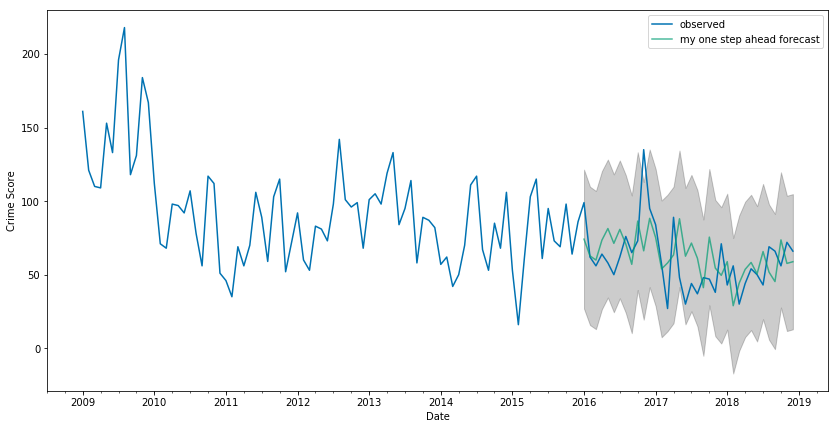

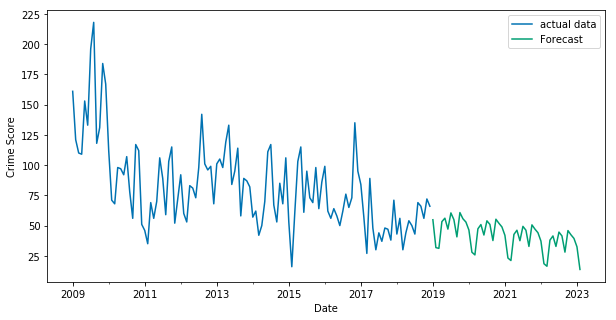

In [3]:
# create table crime_data (
# 	id int primary key,
# 	report_date date,
# 	latitude float,
# 	longitude float,
# 	ucr int,
# 	ucr_literal varchar,
# 	crime_harm_index int)
#
# create table homeaway_listings (
# 	id int primary key,
# 	listingId varchar,
# 	price_amt float,
# 	price_avg_nightly float,
# 	price_fees float,
# 	price_rent float,
# 	latitude float,
# 	longitude float,
# 	city varchar,
# 	state varchar,
# 	country varchar,
# 	review_count int,
# 	review_average float,
# 	bathrooms int,
# 	bedrooms int,
# 	listing_url varchar,
# 	book_with_confidence boolean)
#
# create table yelp_data (
#     id int primary key,
#     name varchar,
#     rating float,
#     review_count int,
#     categories varchar,
#     other_id varchar,
#     location varchar,
#     price varchar,
#     latitude float,
#     longitude float)
#
# ALTER TABLE homeaway_listings
#    ADD COLUMN geo_point
#     geometry(Geometry,0);
#
# UPDATE homeaway_listings SET
#   geo_point = ST_Point(longitude, latitude);
#
#
# ALTER TABLE crime_data
#    ADD COLUMN geo_point
#     geometry(Geometry,0);
#
# UPDATE crime_data SET
#   geo_point = ST_Point(longitude, latitude);
#
# ALTER TABLE yelp_data
#    ADD COLUMN geo_point
#     geometry(Geometry,0);
#
# UPDATE yelp_data SET
#   geo_point = ST_Point(longitude, latitude);
import pandas as pd
import psycopg2
engine = psycopg2.connect(
    database="cse6242team22db",
    user="Team22",
    password="vacayaway",
    host="cse6242-db.cvdup1gpakos.us-east-2.rds.amazonaws.com",
    port='5432'
)

cur = engine.cursor()

# cur.execute("SELECT * FROM crime_data limit 10;")
# print(cur.fetchone())
# cur.execute("SELECT * FROM yelp_data limit 10;")
# print(cur.fetchone())
##cur.execute("SELECT * FROM homeaway_listings limit 10;")
#print(cur.fetchall())

#cur.execute("select * from homeaway_listings hl join crime_data cd on st_distance(hl.geo_point::geography, cd.geo_point::geography) < 300 where hl.id =3;")
#response = cur.fetchall()
#crime_df = pd.DataFrame(response)
#crime_tot = pd.DataFrame()
#print(response)
##crime_tot = pd.DataFrame()
##lst = []
##dic_pred = {}
##dic_y = {}
#for i in range(1,256):

crime_tot = pd.DataFrame()
for i in range(1,4):
    cur = engine.cursor()
    #cur.execute("select * from homeaway_listings hl join crime_data cd on st_distance(hl.geo_point::geography, cd.geo_point::geography) < 300 where hl.id ="+str(i)+";")
    #cur.execute("select * from homeaway_listings hl join crime_data cd on st_distance(hl.geo_point::geography, cd.geo_point::geography) < 300 where hl.id =711;")
    cur.execute("select * from neighborhoods nb join crime_data cd on st_contains(nb.atl_geom, cd.geo_point) where nb.gid = "+str(i)+";")
    response = cur.fetchall()
    crime_df_my = pd.DataFrame(response)
    
    if i == 246:
        cimre_fore = 0
        y = 0
        pred = 0
        
    elif i == 57 or i == 233:
        crime_fore, y, pred = crime_forecasting_none(crime_df_my)
        
    else:
        crime_fore, y, pred = crime_forecasting(crime_df_my)

    #lst.append([i,crime_fore])
    #dic_pred[i] = pred
    #dic_y[i] = y
    
    #crime_tot = pd.DataFrame(lst)
    data = {str(i):crime_fore}
    temp = pd.DataFrame.from_dict(data, orient='index')
    
    crime_tot = pd.concat([crime_tot,temp])

    
#cur.execute("select * from homeaway_listings hl join crime_data cd on st_distance(hl.geo_point::geography, cd.geo_point::geography) < 300 where hl.id = ;")

#cur.execute("SELECT * FROM crime_data limit 100;")
#response = cur.fetchall()
#crime_df = pd.DataFrame(response)



#crime_data = response.json()
#df = pd.DataFrame.from_dict(crime_data)
#print(df)
#cur.execute("select * from homeaway_listings hl join yelp_data yd on st_distance(hl.geo_point::geography, yd.geo_point::geography) < 300 where hl.id = 1;")
#print(cur.fetchone())
#print(cur.fetchone())

#cur.close()
#engine.close()
#business_data = response.json()
#print(business_data['total'])
#df = pd.DataFrame.from_dict(business_data['businesses'])
#df_business = pd.concat([df_business,df],ignore_index = True)